# Farm Card Caculations: Outline

1. Background
2. Notebook Setup
3. The Process
4. Alterations
5. Questions?

# Background

Some content to go here about farm cards.

# Set Up Notebook Environment

As with any bit of code, there are a few things we need to get situated before we really start in.

## Import Modules

We'll be using the following modules in this notebook:

* GeoPandas
* Requests
* MatPlotLib

### [GeoPandas](https://geopandas.org/)

* Spatially enabled extension of **[pandas](https://pandas.pydata.org/)**, a popular Python data manipulation module
* Uses **[Shapely](https://shapely.readthedocs.io/en/latest/)** to handle spatial operations
* Uses **[Fiona](https://fiona.readthedocs.io/en/latest/README.html)** for reading and writing to diverse spatial data and file types


### [Requests](https://docs.python-requests.org/en/master/)

* Easily encode URL requests
* Parse response in a variety of formats
* In this case, used to query ArcGIS Server REST endpoints

### [MatPlotLib](https://matplotlib.org/)

* Well-developed visualization library
* **GeoPandas** (and **pandas**) written with deep MatPlotLib integration

In [1]:
import requests
import geopandas as gp
import matplotlib.pyplot as plt

### A Few Global Variables

There are a few variables that we'll declare here at the top. We do this because:
1. It makes it easier to reference
2. Users wishing to adapt this for their own use don't need to look all over the notebook for where to change things

In [2]:
# Spatial reference for layers
sr = "{'wkid': 3435}"

In [3]:
# Parcels REST service
parcels_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Current_Cadastral_Features/FeatureServer/1/query?'

In [4]:
# SSURGO Soils REST service
soils_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Soils/FeatureServer/0/query?'

In [5]:
# Landuse REST service
landuse_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Landuse/FeatureServer/0/query?'

# Parcels

## Constructing the Query

In this example, we're using a local file, `input_pins.txt`, which contains the PINs listed below:

```txt
07-35-400-005
07-36-300-004
07-36-300-006
07-36-100-001
07-35-200-005
```

We'll use a `with... as` command to temporarily open the file and read its contents into a variable. Using Python list comprehension, `[something(x) for x in y]`, we can succinctly compile a list of strings.

In [7]:
with open('input_pins.txt', 'r') as file:
    pin_list = ["'" + pin + "'" for pin in file.read().split('\n')]

pin_list

["'07-35-400-005'",
 "'07-36-300-004'",
 "'07-36-300-006'",
 "'07-36-100-001'",
 "'07-35-200-005'"]

Why the single-quotes? Because these PINs are going to populate the `where` clause we submit to the REST service. The clause has to be formatted as valid SQL in order to evaluate.

In our query, we'll be filtering the results using `IN` on a **string** field, so each value needs to be quoted out, and being SQL, must be single-quotes to be read as string values.

Also, rather than concatenate multiple strings, we're using Python's *f-strings* to build the where clause.

In [8]:
print(f"pin IN ({','.join(pin_list)})")

pin IN ('07-35-400-005','07-36-300-004','07-36-300-006','07-36-100-001','07-35-200-005')


Next, we assemble the query. For performance, we'll also limit the output fields to only those necessary for the calculation, `pin` and `gross_acres`. We supply the spatial reference defined at the top, and specify GeoJSON as the output format.

We then submit that query to the REST endpoint and use GeoPandas to read the response into a GeoDataFrame.

In [9]:
parcels_params = {
    'where': f"pin IN ({','.join(pin_list)})",
    'outFields': 'gross_acres, pin',
    'outSR': sr,
    'f': 'geojson'
}

In [10]:
parcels = requests.get(parcels_url, parcels_params)

In [11]:
p_df = gp.read_file(parcels.text)

To check on the output, we'll call the method `head` on our dataframe. This returns up to 5 of the first rows of the dataframe, and is an easy way to glance at a subset of the data when working with larger datasets.

In [12]:
p_df.head()

,gross_acres,pin,geometry
0,5.99,07-36-300-006,"POLYGON ((939027.737 1747725.599, 939027.787 1..."
1,155.46,07-36-300-004,"POLYGON ((939557.870 1747744.270, 939027.787 1..."
2,40.00,07-36-100-001,"POLYGON ((939557.510 1747764.271, 939533.900 1..."
3,69.88,07-35-400-005,"POLYGON ((936901.360 1747718.210, 936901.020 1..."
4,81.17,07-35-200-005,"POLYGON ((936901.020 1747738.210, 938232.990 1..."


With spatial objects, too, it can be helpful to see the shapes, so we'll also make use of the `plot` method. Note that in standard pandas, this returns a graph. In GeoPandas, however, [plot](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.plot.html?highlight=plot#geopandas.GeoDataFrame.plot) will look for a geometry column to visualize instead.

<AxesSubplot:>

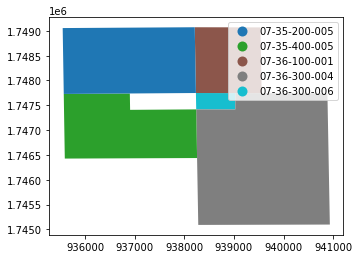

In [13]:
p_df.plot(column='pin', legend=True)

## Adding Calculated Area

In order to accurately calculate our farm cards, we'll be using the calculated area of the geometry in the given spatial reference. *Deeded* acreage trumps *actual* acreage, though, so we need to be able to scale our calculations accordingly.

To do this, we'll create a new column in the dataframe, `calc_area`. GeoDataFrames have a built-in property `area`, which returns the area of the shape in the given spatial reference.

Note that dataframes are similar to dictionaries in other languages, in that new keys / columns can be defined simply by assigning a value to `dataframe['newcolumn']`.

In [14]:
p_df['calc_area'] = p_df.area

In [15]:
p_df.head()

,gross_acres,pin,geometry,calc_area
0,5.99,07-36-300-006,"POLYGON ((939027.737 1747725.599, 939027.787 1...",2.611347e+05
1,155.46,07-36-300-004,"POLYGON ((939557.870 1747744.270, 939027.787 1...",6.768869e+06
2,40.00,07-36-100-001,"POLYGON ((939557.510 1747764.271, 939533.900 1...",1.756259e+06
3,69.88,07-35-400-005,"POLYGON ((936901.360 1747718.210, 936901.020 1...",3.042915e+06
4,81.17,07-35-200-005,"POLYGON ((936901.020 1747738.210, 938232.990 1...",3.533025e+06


You'll notice the calculated area is in square feet, not acres. The calculated units don't actually matter, though, as will be evident later on. For now, we have enough to move on to our other layers.

# Landuse and Soils

## Spatial Filter

In order to get only those features which are relevant to the above parcels, we need need to supply a **spatial filter** for our query.

If we wanted to be fancy, we *could* submit the individual geometries themselves. But let's keep things simple. As we are working with contiguous parcels in a small area, we just need an envelope that contains all of them.

GeoDataFrames have another useful property, `total_bounds`. This returns an array of the min/max x and y of all the features.

In [18]:
p_df.total_bounds

array([ 935547.63003691, 1745088.97999482,  940932.34991049,
       1749073.16001857])

We'll be constructing an **esriGeometryEnvelope** for the spatial filter, which needs to be in the format `'min_x, min_y, max_x, max_y'`.

We can't use `join` on *float* objects, so we'll use some more list comprehension to convert the list to *strings* first.

In [19]:
bbox = ','.join([str(i) for i in p_df.total_bounds])

bbox

'935547.6300369129,1745088.9799948186,940932.3499104939,1749073.1600185707'

## Constructing Queries

The queries for our landuse and soils data will actually be the same.

We want all the fields of all the features that *intersect* with the `bbox` geometry we just made.

In [20]:
farm_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': True,
    'geometryType': 'esriGeometryEnvelope',
    'geometry': bbox,
    'spatialRel': 'esriSpatialRelIntersects',
    'outSR': sr,
    'f': 'geojson'
}

### Soils

In [21]:
soils = requests.get(soils_url, farm_params)

s_df = gp.read_file(soils.text)

In [22]:
s_df.head()

,objectid,musym,globalid,soil_type,slope,SHAPE__Length,SHAPE__Area,geometry
0,394,145B,{2D794A20-B7EF-45FF-B655-F855FC78D003},145,B1,5383.604829,9.445314e+05,"POLYGON ((936003.251 1749618.066, 935921.164 1..."
1,1685,148A,{5EBBE6AD-7B76-4A12-A35C-D9F265C7EED9},148,A1,15587.239787,3.654991e+06,"POLYGON ((937346.980 1749254.753, 937291.739 1..."
2,1687,148A,{0B178009-AC76-4C21-9DE8-6EBC831ABFC7},148,A1,1937.991528,2.746759e+05,"POLYGON ((938637.996 1749031.941, 938688.959 1..."
3,1691,148A,{1133755D-D7B5-43DD-B8EA-DE8C741F2C79},148,A1,16601.097438,5.418792e+06,"POLYGON ((940237.499 1750323.332, 940178.465 1..."
4,1805,148B,{F4BF534B-E5FC-4DCA-A06B-852CB138650D},148,B1,7334.794554,9.237701e+05,"POLYGON ((934847.255 1745199.208, 934876.396 1..."


### Landuse

In [23]:
landuse = requests.get(landuse_url, farm_params)

l_df = gp.read_file(landuse.text)

In [24]:
l_df.head()

,objectid,landuse,globalid,landuse_type,SHAPE__Length,SHAPE__Area,geometry
0,1739,CR,{180B5AB0-6384-457A-A27B-600364F279D4},2,5471.262603,1.285937e+06,"POLYGON ((934712.266 1745074.442, 934958.210 1..."
1,1740,CR,{12ECCE76-2254-458E-91A3-0F546F3C27A3},2,1672.684633,8.767614e+04,"POLYGON ((935556.525 1747280.123, 935549.610 1..."
2,1741,CR,{79E92BF8-DF93-46E0-8951-28EFF402B7DB},2,13225.049770,6.456598e+06,"POLYGON ((943529.140 1746253.643, 943527.871 1..."
3,1742,CR,{6788F7F1-D79C-48A1-97E3-2EC676726216},2,9891.950064,4.907331e+06,"POLYGON ((939564.102 1747418.142, 939558.640 1..."
4,1743,CR,{4CF43653-D762-4AB6-8538-EEE9CE9AEDDA},2,2277.846824,1.612382e+05,"MULTIPOLYGON (((938512.191 1747711.903, 938233..."


## Wrap it Up: Visualization

Before moving on, let's visualize our dataframes all together.

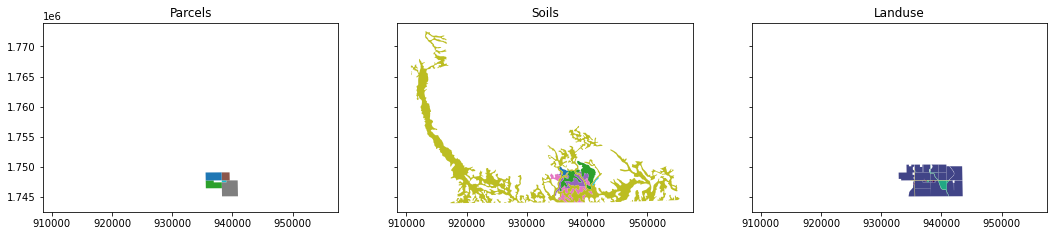

In [30]:
fig, axs = plt.subplots(1,3, figsize=(18,10), sharex=True, sharey=True)

p_df.plot(column='pin', ax=axs[0])
s_df.plot(column='musym', ax=axs[1])
l_df.plot(column='landuse_type', ax=axs[2])

axs[0].set_title('Parcels')
axs[1].set_title('Soils')
axs[2].set_title('Landuse')

plt.show()

# Spatial Analysis

We have our intersecting dataframes, now we need to bring them together. We'll be using the GeoPandas method `overlay`, which combines two dataframes based on a spatial relationship.

For our purposes, we will be using **intersection**, as we are only interested in the areas that truly overlap.

In [ ]:
df = gp.overlay(p_df, s_df, how='intersection')
df = gp.overlay(df, l_df, how='intersection')

In [ ]:
df_keeps = [
    'gross_acres',
    'gis_acres',
    'calc_area',
    'pin',
    'soil_type',
    'slope',
    'landuse_type',
    'geometry'
]

for c in df:
    if c not in df_keeps:
        del df[c]

df.head()

In [ ]:
df = df.assign(part_acres=df['gross_acres'] / df['calc_area'] * df.area)
df.drop(['gross_acres', 'calc_area'], axis=1, inplace=True)

df.head()

In [ ]:
out_cols = ['pin', 'soil_type', 'slope', 'landuse_type']

# Dashes out of PIN
df['pin'] = df['pin'].str.replace('-', '')

# Prepend LU w/ 0
df['landuse_type'] = df['landuse_type'].astype('str')

# Sort values
df.sort_values(by=out_cols, ignore_index=True, inplace=True)

# Group identical columns, sum acreage
df = df.groupby(by=out_cols, as_index=False).sum()

# Round acreage
df['part_acres'] = round(df['part_acres'], 4)

# Drop rows w/ 0 acreage
df = df[df['part_acres'] > 0]

In [ ]:
df.to_csv(f'./farm_output_{datetime.now().strftime("%Y%m%d")}.txt', sep='\t', header=False, index=False)